<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [42]:
# Подключаем все необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Разбиение на обучающую, валидационную и тестовую выборку
from sklearn.model_selection import train_test_split
# Точность модели
from sklearn.metrics import accuracy_score
# Масштабируемость модели
from sklearn.preprocessing import StandardScaler

# и для машинного обучения разными способами:
# - Случайный лес
from sklearn.ensemble import RandomForestClassifier
# - Решающее дерево
from sklearn.tree import DecisionTreeClassifier
# - Модель на адекватность
from sklearn.dummy import DummyClassifier

# Матрицы ошибок (для борьбы с дисбалансом)
from sklearn.metrics import confusion_matrix
# Полнота
from sklearn.metrics import recall_score
# Точность
from sklearn.metrics import precision_score
# F1-мера
from sklearn.metrics import f1_score
# Контроль выборки
from sklearn.utils import shuffle
# Порог
from sklearn.metrics import precision_score, recall_score
# Метрика AUC-ROC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [2]:
# Получаем датасет
try:
    df = pd.read_csv('/datasets/Churn.csv')

    # Узнаем, что в нем
    df.info()
except:
    print('Отсутствует датасет. Проверьте путь файла')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
# Проверим на наличие пропущенных значений
df.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

Себе на пометку:
Если в каком то признаке пустые значения, то его следует заполнять, иначе выводит ошибку такого рода: "Input contains NaN, infinity or a value too large for dtype('float32')"


In [5]:
# Заполняем пропуски медианным значением
df['Tenure'] = df['Tenure'].fillna(df['Tenure'].median())

In [6]:
# Снова проверим на пропущенные значения
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

## Исследование задачи

In [7]:
# Уклоняемся от дамми-ловушек
df = pd.get_dummies(df, drop_first=True)

In [8]:
# Получаем признак и цель 
features = df.drop('Exited', axis=1)
target = df['Exited']

In [9]:
# Как обычно, будем разделять 60% данных для обучающей выборки, а features_temp и target_temp будут временным датафреймом
features_train, features_temp, target_train, target_temp = train_test_split(features, target, test_size= (1 - 0.6), random_state=12345) 

In [10]:
# А тестовая и валидационная - по 20% данных
features_valid, features_test, target_valid, target_test = train_test_split(features_temp, target_temp, test_size=(1 - 0.5), random_state=12345)

In [11]:
# Масштабируем признаки: обучающую, валидационную и тестовую выборку
scaler = StandardScaler()

# Выберем подходящие признаки по порядку (количественные, а не категориальные)
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

scaler.fit(features_train[numeric])

# Преобразуем обучающую, валидационную и тестовую выборки функцией transform()
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

# Чтобы предупреждение не появлялось
pd.options.mode.chained_assignment = None

/tmp/ipykernel_48/3478311116.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_48/3478311116.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [12]:
# Проверим
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(6000, 2944)
(2000, 2944)
(2000, 2944)


In [13]:
features_train.head()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,Surname_Zotova,Surname_Zox,Surname_Zubarev,Surname_Zubareva,Surname_Zuev,Surname_Zuyev,Surname_Zuyeva,Geography_Germany,Geography_Spain,Gender_Male
7479,7480,15671987,-0.886751,-0.373192,8.0,1.232271,1,1,0,-0.187705,...,0,0,0,0,0,0,0,0,1,1
3411,3412,15815628,0.608663,-0.183385,8.0,0.600563,1,0,0,-0.333945,...,0,0,0,0,0,0,0,0,0,0
6027,6028,15799494,2.052152,0.480939,3.0,1.027098,2,0,1,1.503095,...,0,0,0,0,0,0,0,1,0,1
1247,1248,15711288,-1.457915,-1.417129,6.0,-1.233163,2,1,0,-1.071061,...,0,0,0,0,0,0,0,0,0,1
3716,3717,15699492,0.130961,-1.132419,2.0,1.140475,1,0,0,1.524268,...,0,0,0,0,0,0,0,1,0,0


Все в порядке, переходим дальше

In [14]:
# Примененим методом решающего дерева
model = DecisionTreeClassifier(random_state=12345)

model.fit(features_train, target_train)

predicted_valid = model.predict(features_valid)
accuracy_valid = accuracy_score(target_valid, predicted_valid) 

In [15]:
accuracy_valid

0.8205

In [16]:
# Получим предсказания тестовой модели
test_predictions = model.predict(features_test)
print("Тестовая выборка:", accuracy_score(target_test, test_predictions))

Тестовая выборка: 0.808


In [17]:
# А теперь применим методом случайного леса
best_model = None
best_result = 0
for est in range(1, 11):
    # Обучим модель с заданным количеством деревьев
    model = RandomForestClassifier(random_state=12345, n_estimators=est) 
    
    # Обучим модель на тренировочной выборке
    model.fit(features_train, target_train) 
    
    # Посчитаем качество модели на валидационной выборке
    result = model.score(features_valid, target_valid) 
    
    if result > best_result:
        # Сохраним наилучшую модель
        best_model = model
        # Сохраним наилучшее значение метрики accuracy на валидационных данных
        best_result = result

In [18]:
print("Accuracy наилучшей модели на валидационной выборке:", best_result)

Accuracy наилучшей модели на валидационной выборке: 0.8415


In [19]:
# Получим предсказания тестовой модели
test_predictions = model.predict(features_test)
print("Тестовая выборка:", accuracy_score(target_test, test_predictions))

Тестовая выборка: 0.83


In [20]:
# Проверим модель на адекватность

# Устанавливаем стратегию прогноза как "самый частый случай", 
# т.е. частую метку класса в наблюдаемом аргументе target, 
# переданном для соответствия
dummy_clf = DummyClassifier(strategy = "most_frequent")

# Обучим модель
dummy_clf.fit(features_train, target_train)

# Создаем модель, указав стратению как "самый частый случай"
DummyClassifier(strategy = 'most_frequent')

# Получим предсказания модели
dummy_clf.predict(features_train)

# Посчитаем качество модели
dummy_clf.score(features_train, target_train)

0.8006666666666666

Можно сказать, что метод обучения "Решающего дерева" эффективный, т.к. модель на тестовой выборке показала себя лучше остальных.

Но данные модели "Решающего дерева" и модели на адекватность почти одинаковые, разница лишь 2%, будем бороться с дисбалансом

## Борьба с дисбалансом

In [21]:
confusion_matrix(target_valid,predicted_valid)

array([[1443,  139],
       [ 220,  198]])

Здесь получается, что 
- TN; FP
- FN; TP


TN - истинно отрицательные ответы (1443)

FP - ложноотрицательные ответы (139)

FN - ложноположительные ответы (220)

TP - истинно положительные ответы (198)

Здесь значения TN намного превысили остальных

In [22]:
# Выявляем полноту, т.е. долю TP-ответов среди всех, у которых истинная метка 1. 
# Хорошо, когда значение recall близко к единице: модель хорошо ищет положительные объекты. 
# Если ближе к нулю — модель надо перепроверить и починить.

recall_score(target_valid, predicted_valid)

0.47368421052631576

Здесь приблизилась к золотой середине, ни плохо, ни слишком идеально

In [23]:
# Выявляем точность, т.е. как много отрицательных ответов нашла модель, пока искала положительные. 
# Чем больше отрицательных, тем ниже точность.
precision_score(target_valid, predicted_valid)

0.5875370919881305

Здесь точность нам удовлетворит

In [24]:
# Выявляем F1-меру, т.е. соотношение полноты и точности
f1_score(target_valid, predicted_valid)

0.5245033112582781

Здесь получилось меньше по заявленному требованию - 0.59

In [25]:
# Создадим функуцию для контроля выборки
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [26]:
# Вызываем функцию
features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

In [27]:
# Попробуем увеличить F1-меру методом "Решающего дерева"
model = DecisionTreeClassifier(random_state=12345)

model.fit(features_upsampled, target_upsampled)

predicted_valid = model.predict(features_valid)

score = model.score(features_valid, target_valid)

In [28]:
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5464362850971923


Не так уж сильно увеличился, лишь на 2%. Попробуем методом случайного леса

In [29]:
# А теперь применим методом случайного леса
best_model = None
best_result = 0
for est in range(1, 11):
    # Обучим модель с заданным количеством деревьев
    model = RandomForestClassifier(random_state=12345, n_estimators=est) 
    
    # Обучим модель на тренировочной выборке
    model.fit(features_upsampled, target_upsampled)
    
    # Посчитаем качество модели на валидационной выборке
    result = model.score(features_valid, target_valid) 
    
    if result > best_result:
        # Сохраним наилучшую модель
        best_model = model
        # Сохраним наилучшее значение метрики accuracy на валидационных данных
        best_result = result

In [30]:
# Получаем предсказания
predicted_valid = model.predict(features_valid)

In [31]:
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.46839080459770116


Стало хуже, уменьшился на 8%. Попробуем уменьшить выборку

In [32]:
# Создадим функцию, которая будет уменьшать выборки
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [33]:
# Вызываем функцию
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

In [34]:
# Попробуем увеличить F1-меру методом "Решающего дерева"
model = DecisionTreeClassifier(random_state=12345)

model.fit(features_downsampled, target_downsampled)

predicted_valid = model.predict(features_valid)

score = model.score(features_valid, target_valid)

In [35]:
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.4589947089947089


Еще хуже. Другой метод попробуем

In [36]:
# А теперь применим методом случайного леса
best_model = None
best_result = 0
for est in range(1, 11):
    # Обучим модель с заданным количеством деревьев
    model = RandomForestClassifier(random_state=12345, n_estimators=est) 
    
    # Обучим модель на тренировочной выборке
    model.fit(features_downsampled, target_downsampled)
    
    # Посчитаем качество модели на валидационной выборке
    result = model.score(features_valid, target_valid) 
    
    if result > best_result:
        # Сохраним наилучшую модель
        best_model = model
        # Сохраним наилучшее значение метрики accuracy на валидационных данных
        best_result = result

# Получаем предсказания
predicted_valid = model.predict(features_valid)

In [37]:
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.4281490242460083


Не совсем уж так сильно увеличился, остался на уровне

In [38]:
# Проверим на порог
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.3, 0.02):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    f1 = f1_score(target_valid, predicted_valid)
    
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}, F1 = {:.5f}".format(threshold, precision, recall, f1))

Порог = 0.00 | Точность = 0.209, Полнота = 0.998, F1 = 0.34563
Порог = 0.02 | Точность = 0.209, Полнота = 0.998, F1 = 0.34563
Порог = 0.04 | Точность = 0.209, Полнота = 0.998, F1 = 0.34563
Порог = 0.06 | Точность = 0.209, Полнота = 0.998, F1 = 0.34563
Порог = 0.08 | Точность = 0.209, Полнота = 0.998, F1 = 0.34563
Порог = 0.10 | Точность = 0.212, Полнота = 0.990, F1 = 0.34893
Порог = 0.12 | Точность = 0.212, Полнота = 0.990, F1 = 0.34893
Порог = 0.14 | Точность = 0.212, Полнота = 0.990, F1 = 0.34893
Порог = 0.16 | Точность = 0.212, Полнота = 0.990, F1 = 0.34893
Порог = 0.18 | Точность = 0.212, Полнота = 0.990, F1 = 0.34893
Порог = 0.20 | Точность = 0.220, Полнота = 0.986, F1 = 0.35998
Порог = 0.22 | Точность = 0.220, Полнота = 0.986, F1 = 0.35998
Порог = 0.24 | Точность = 0.220, Полнота = 0.986, F1 = 0.35998
Порог = 0.26 | Точность = 0.220, Полнота = 0.986, F1 = 0.35998
Порог = 0.28 | Точность = 0.220, Полнота = 0.986, F1 = 0.35998


<div class="alert alert-block alert-info">

Изменяя значение порога, F1 не так уж сильно меняется, есть у меня недотчеты? Если против, то после того как у меня получится превысить значения 0.58 проведу тестирование (в 4 пункте)?
    
</div>

In [39]:
# Попробуем применить методом "Решающего дерева"
model = DecisionTreeClassifier(random_state=12345)

model.fit(features_train, target_train)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

In [40]:
auc_roc

0.6929103732783285

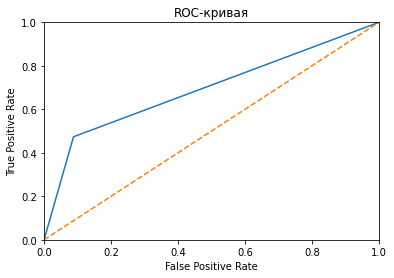

In [43]:
# Изображаем ROC-кривую
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()

plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')
plt.show()

In [44]:
# Попробуем применить методом "Случайного дерева"
best_model = None
best_result = 0
for est in range(1, 11):
    # Обучим модель с заданным количеством деревьев
    model = RandomForestClassifier(random_state=12345, n_estimators=est) 
    
    # Обучим модель на тренировочной выборке
    model.fit(features_downsampled, target_downsampled)
    
    # Посчитаем качество модели на валидационной выборке
    result = model.score(features_valid, target_valid) 
    
    if result > best_result:
        # Сохраним наилучшую модель
        best_model = model
        # Сохраним наилучшее значение метрики accuracy на валидационных данных
        best_result = result

# Получаем предсказания
predicted_valid = model.predict(features_valid)

In [45]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

In [46]:
auc_roc

0.7330509499815508

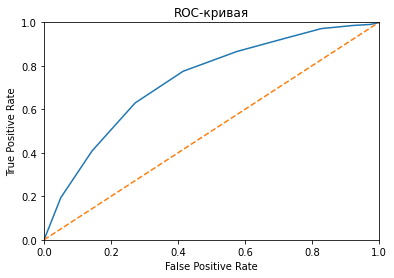

In [47]:
# Изображаем ROC-кривую
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()

plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')
plt.show()

Здесь намного получше, чем методм "Решающее дерево"

## Тестирование модели

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [ ]  Выполнен шаг 4: проведено тестирование
- [ ]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*